In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from isochrones import get_ichrone, SingleStarModel, BinaryStarModel

Holoviews not imported. Some visualizations will not be available.


In [2]:
from astroquery.mast import Observations, Catalogs

res = Catalogs.query_criteria(catalog="Tic", ID=165991532).to_pandas()

/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
res

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,165991532,20190415,68756,4174-01262-1,772-036991,14042335+6422331,NaN,J140423.31+642233.6,1667976701458550400,NaN,...,NaN,12.111298,9.383518,211.096762,64.375923,0.320942,0.278278,0,0,150439321


In [4]:
np.sin(np.radians(86.35))

0.9979715533496006

In [5]:
np.radians(86.35)

1.5070918090971035

In [6]:
def create_param_list(row):
    params = {}
    
    # Plug in magnitudes
    band_key = [
        'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 
            'J', 'H', 'K',
#         'Tycho_V'
               'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 
               ]
    bands = [
        'gaiabp','gaiarp',
           'Jmag','Hmag','Kmag',
#         'Tycho VTmag'
            'w1mag','w2mag','w3mag','w4mag',
    ]
    avail_passbands = []
    for band, key in zip(bands, band_key):
        if not np.isnan(row[band]) and not np.isnan(row[f"e_{band}"]):
            params.update({
                 key: (row[band], row[f"e_{band}"])
#                 key: (row[band], row[f"e_Vmag_x"])
            })
            avail_passbands.append(key)
            
    # Time for some fundamental parameters. yeah baby!
    fund = ['Teff', 'logg', 'plx']
    keys = ['Teff', 'logg', 'parallax']
    
    for f, key in zip(fund, keys):
        if not np.isnan(row[f]) and not np.isnan(row[f"e_{f}"]):
            params.update({
                key: (row[f], row[f"e_{f}"])
            })
            
    return params, avail_passbands

In [7]:
def fit_isochrone(params, pb):
    mist = get_ichrone('mist', bands=pb)
    
    mod = SingleStarModel(mist, **params)
    mod.fit()
    
#     mod_binary = BinaryStarModel(mist, **params)
#     mod_binary.fit()
    
    return mod# Greater than 1 it favours the single model.. etc

In [8]:
params, pb = create_param_list(res.iloc[0])
params['Teff'] = (9975, 125)
params['logg'] = (3.63, 0.20)

In [9]:
mod_binary = fit_isochrone(params, pb)

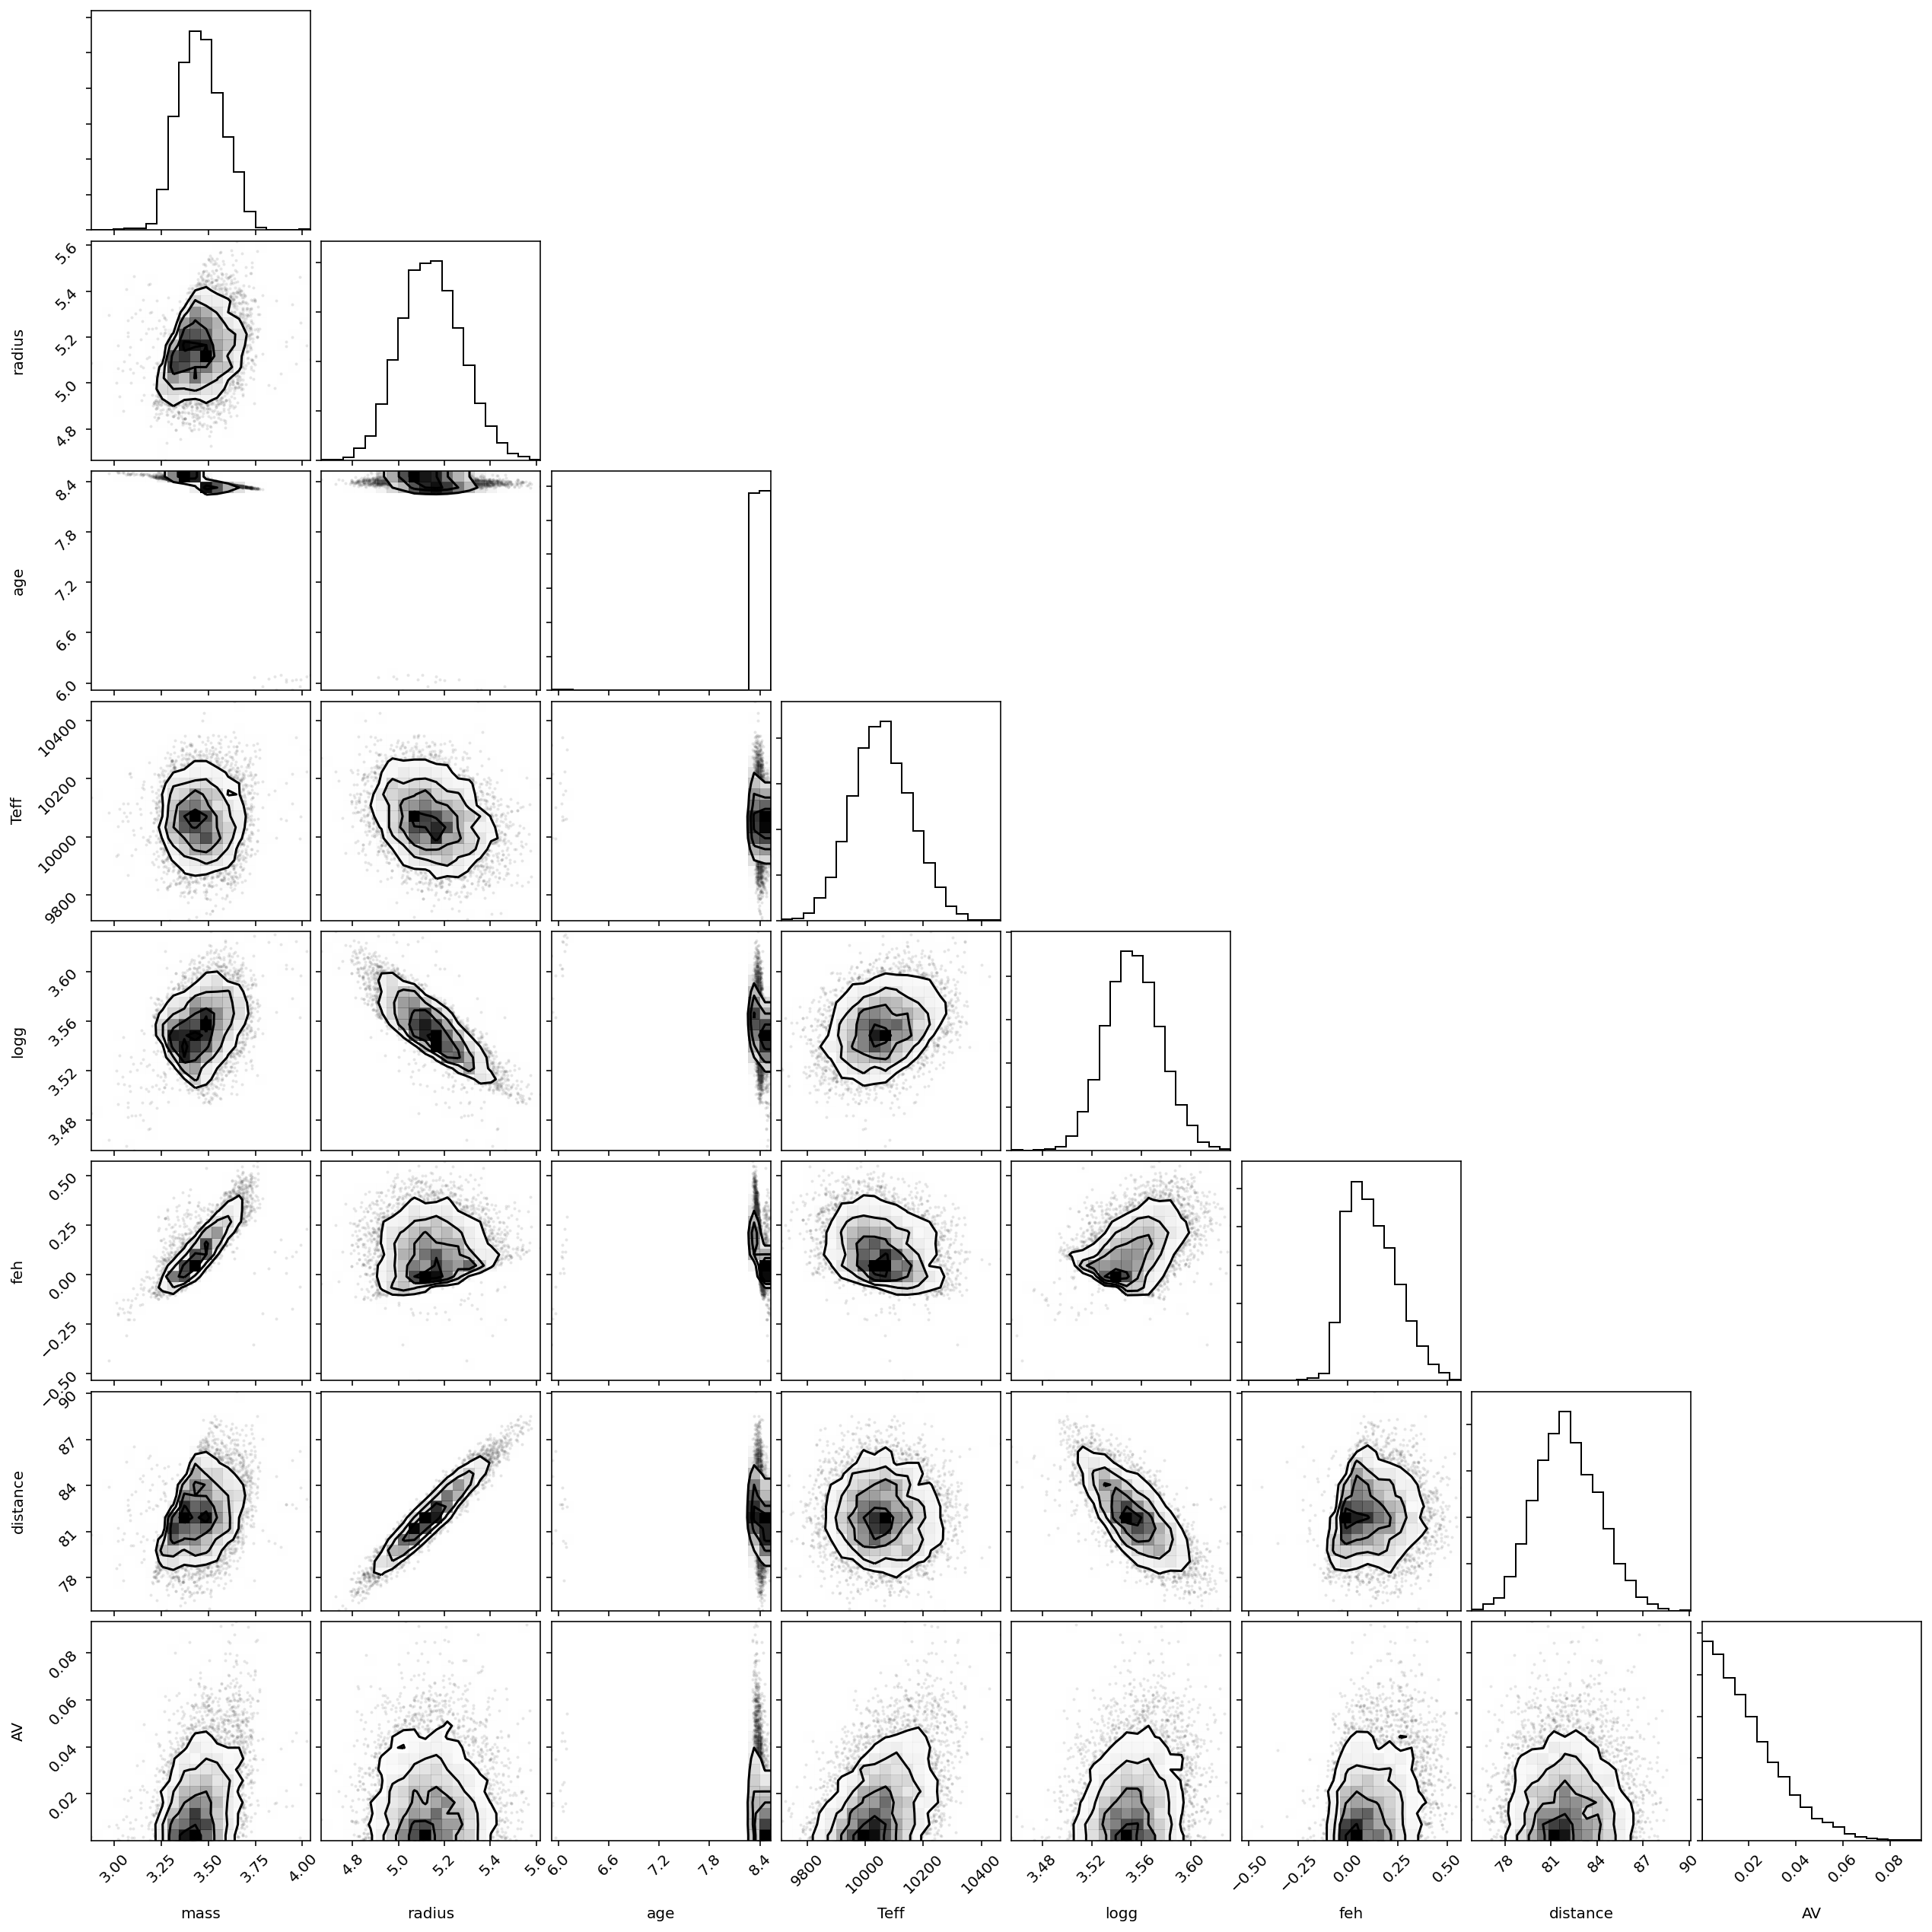

In [10]:
mod_binary.corner_physical();

In [11]:
mod = mod_binary

In [12]:
mod.derived_samples.columns

Index(['eep', 'age', 'feh', 'mass', 'initial_mass', 'radius', 'density',
       'logTeff', 'Teff', 'logg', 'logL', 'Mbol', 'delta_nu', 'nu_max',
       'phase', 'dm_deep', 'Gaia_BP_DR2Rev_mag', 'Gaia_RP_DR2Rev_mag', 'J_mag',
       'H_mag', 'K_mag', 'WISE_W1_mag', 'WISE_W2_mag', 'WISE_W3_mag',
       'WISE_W4_mag', 'parallax', 'distance', 'AV'],
      dtype='object')

In [13]:
10**np.median(mod.derived_samples.logL)

242.41435658998338

In [14]:
mod.derived_samples.Mbol

0      -1.178571
1      -1.270736
2      -1.313847
3      -1.414691
4      -1.085068
          ...   
5836   -1.291948
5837   -1.208329
5838   -1.208329
5839   -1.221396
5840   -1.228674
Name: Mbol, Length: 5841, dtype: float64

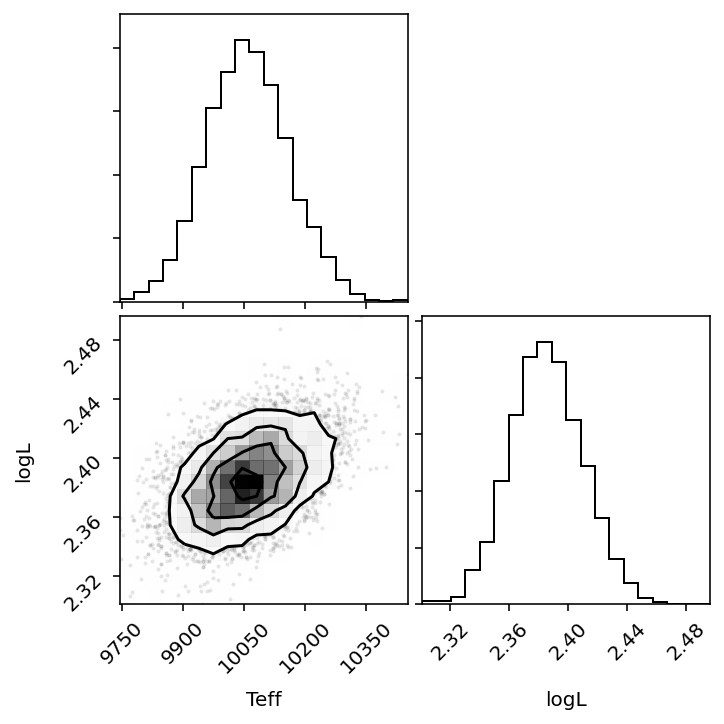

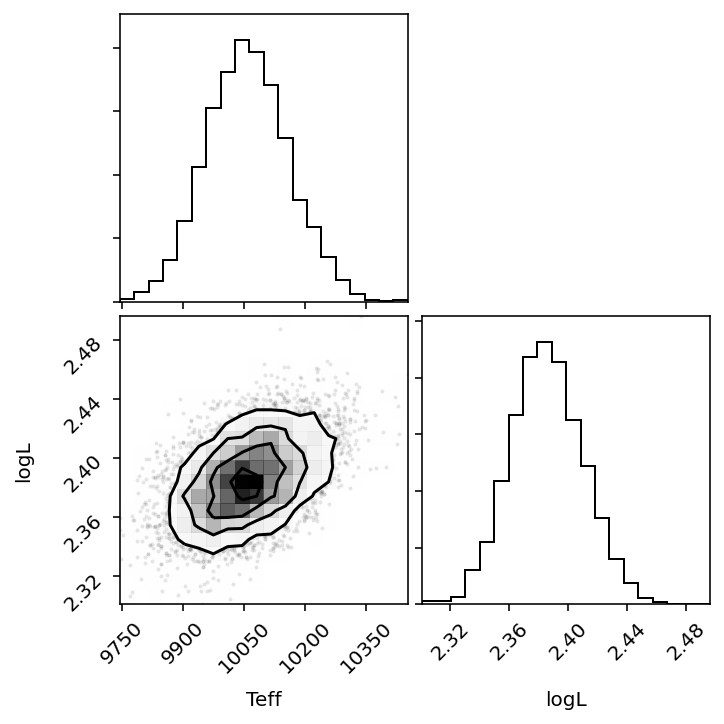

In [35]:
mod.corner_derived(cols=['Teff', 'logL'])

In [47]:
mod.derived_samples

,eep,age,feh,mass,initial_mass,radius,density,logTeff,Teff,logg,...,J_mag,H_mag,K_mag,WISE_W1_mag,WISE_W2_mag,WISE_W3_mag,WISE_W4_mag,parallax,distance,AV
0,393.638682,8.444182,0.012353,3.289475,3.291518,5.111186,0.034974,3.992782,9838.097475,3.538560,...,3.662039,3.669095,3.676017,3.679381,3.682217,3.686419,3.694853,12.643252,79.093573,0.028821
1,171.932557,5.932870,-0.269189,3.774453,3.774463,5.121965,0.040664,4.006468,10156.683454,3.598011,...,3.673800,3.683271,3.692127,3.696800,3.700076,3.703888,3.710958,12.389837,80.711313,0.041032
2,402.759715,8.400147,0.111401,3.509479,3.511789,5.408412,0.031584,4.009642,10228.484073,3.516961,...,3.667213,3.673809,3.681954,3.686014,3.689439,3.695509,3.705618,11.691662,85.531039,0.091190
3,471.530355,8.507385,-0.665129,2.870949,2.872686,5.264018,0.028191,4.005952,10143.502219,3.454651,...,3.681286,3.690287,3.700160,3.704415,3.707167,3.709056,3.713563,12.039295,83.061340,0.021200
4,452.673849,8.467657,-0.221934,3.141419,3.143438,5.101631,0.033422,4.017839,10421.113305,3.519884,...,3.691345,3.704276,3.716840,3.724106,3.728563,3.734380,3.742598,12.074770,82.817312,0.038546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,395.319882,8.422381,-0.004348,3.360687,3.362815,5.216469,0.033748,4.001240,10033.606948,3.530460,...,3.690939,3.703557,3.714499,3.721128,3.725373,3.731317,3.740320,12.045375,83.019413,0.005704
5852,394.158587,8.403232,0.008094,3.415570,3.417698,5.248117,0.033573,4.004691,10111.663336,3.532050,...,3.695715,3.709646,3.721640,3.729177,3.733845,3.740450,3.749834,11.866042,84.274096,0.003936
5853,394.225765,8.424775,0.001219,3.347746,3.349836,5.176334,0.034344,3.999363,9989.861533,3.535358,...,3.686244,3.698255,3.708640,3.714852,3.718911,3.724599,3.733504,12.198292,81.978692,0.006071
5854,393.740388,8.417411,0.031987,3.380266,3.382367,5.234305,0.033325,3.998120,9958.907868,3.529409,...,3.685484,3.697509,3.707858,3.714087,3.718177,3.724010,3.733113,12.065157,82.883298,0.002569


In [15]:
from IPython.display import display, Math

for i in ['mass', 'logL', 'radius', 'Teff']:
    mcmc = np.percentile(mod.derived_samples[i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
#     display(Math(txt))
    print(txt)

\mathrm{mass} = 3.455_{-0.113}^{+0.127}
\mathrm{logL} = 2.385_{-0.023}^{+0.026}
\mathrm{radius} = 5.139_{-0.129}^{+0.138}
\mathrm{Teff} = 10054.298_{-95.646}^{+106.014}


# Estimating the sec

In [59]:
M2 = 2.49978
M2 * np.sqrt( (3 * (0.04 / 86.35))**2 + (2 * (0.1 / 3.5))**2)

0.1428868074935514

In [60]:
40 / 240

0.16666666666666666

In [18]:
import numpy as np
import astropy.units as u
import astropy.constants as c


In [25]:
((1 * u.M_sun).to(u.g) / ((1 * u.R_sun).to(u.cm)**2)) * c.G.to(u.cm**3 / (u.g * u.s**2))

<Quantity 27420.01116574 cm / s2>

In [26]:
np.log10(27420)

4.438067450453494

In [27]:
1 / 3.5

0.2857142857142857

In [37]:
np.log10(40)

1.6020599913279623

In [38]:
mod_binary.derived_samples.columns

Index(['eep_0', 'eep_1', 'age', 'feh', 'distance', 'AV', 'lnprob', 'feh_0',
       'mass_0', 'initial_mass_0', 'radius_0', 'density_0', 'logTeff_0',
       'Teff_0', 'logg_0', 'logL_0', 'Mbol_0', 'delta_nu_0', 'nu_max_0',
       'phase_0', 'dm_deep_0', 'V_mag_0', 'J_mag_0', 'H_mag_0', 'K_mag_0',
       'feh_1', 'mass_1', 'initial_mass_1', 'radius_1', 'density_1',
       'logTeff_1', 'Teff_1', 'logg_1', 'logL_1', 'Mbol_1', 'delta_nu_1',
       'nu_max_1', 'phase_1', 'dm_deep_1', 'V_mag_1', 'J_mag_1', 'H_mag_1',
       'K_mag_1', 'V_mag', 'J_mag', 'H_mag', 'K_mag', 'parallax'],
      dtype='object')

In [39]:
np.median(mod_binary.derived_samples.logL_1)

-2.093377483405772

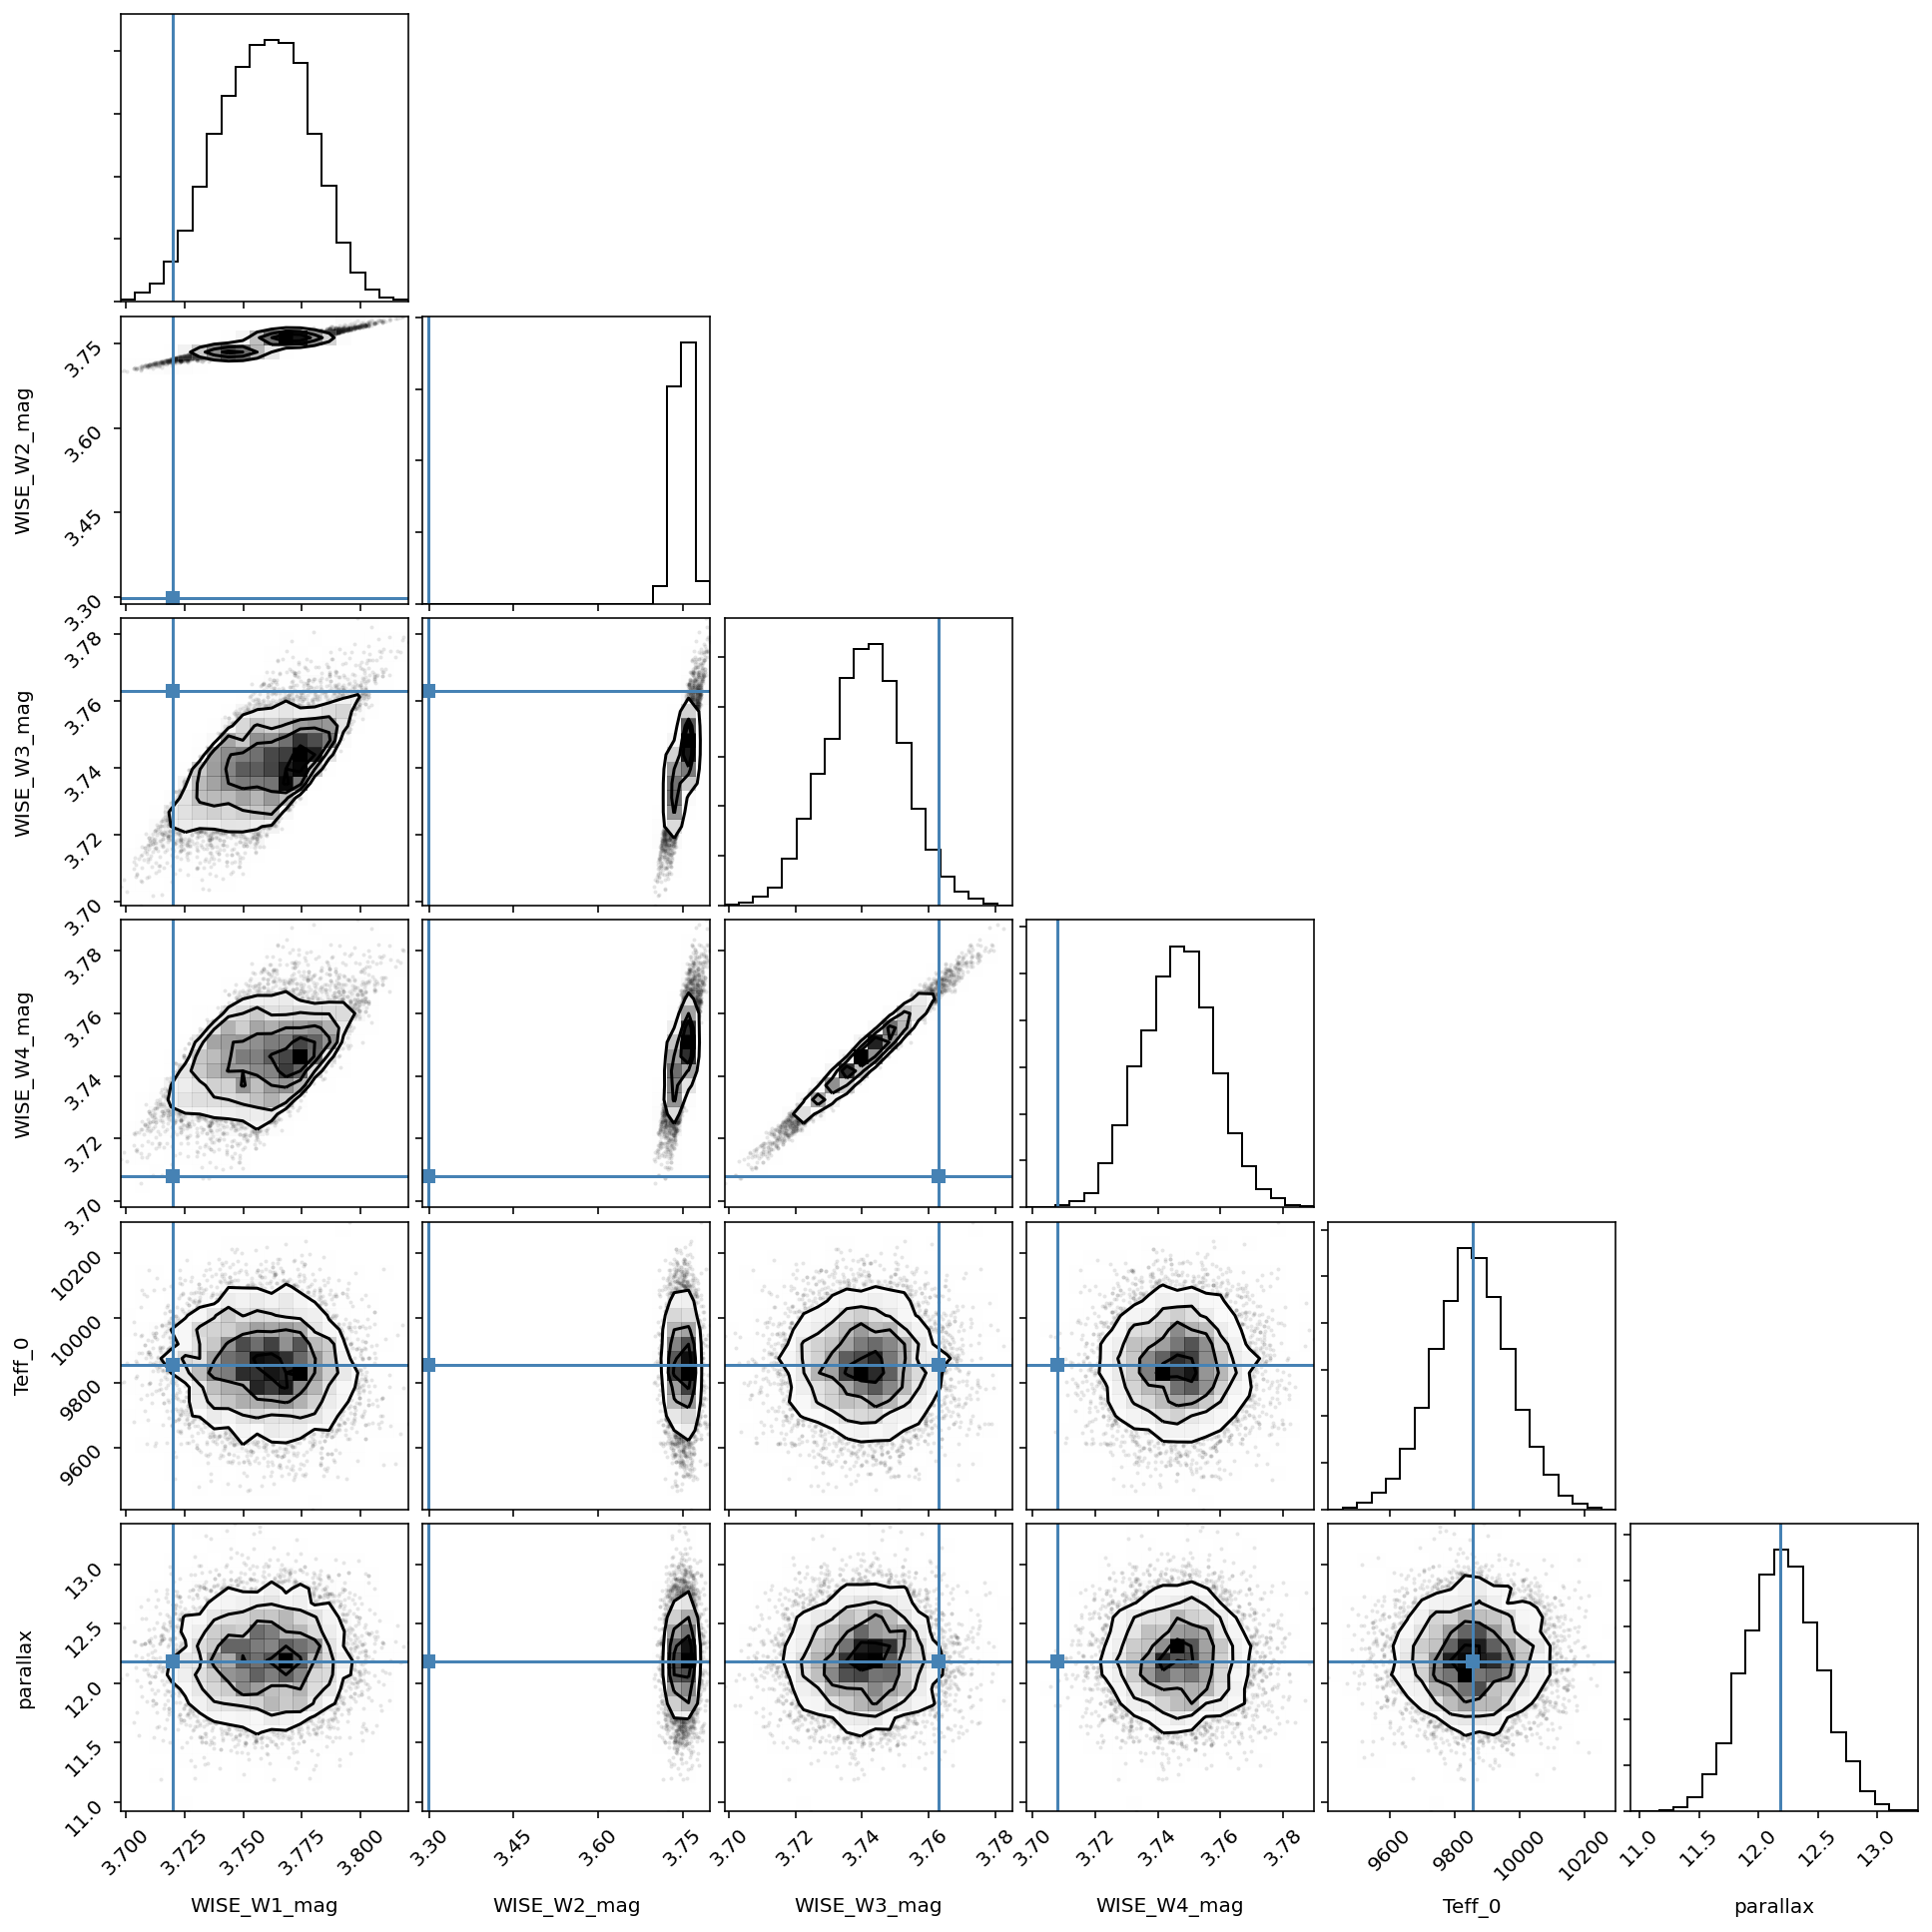

In [46]:
mod_binary.corner_observed();

In [52]:
L ~ M**(3.5)

10**3.42



SyntaxError: invalid syntax (<ipython-input-52-b054fd0f6414>, line 1)